## Multilayer Perceptron (MLP) — End-to-End Workflow

We’ll build a full supervised multiclass classification pipeline using a Multilayer Perceptron:
	•	Data Exploration: load, inspect, visualize
	•	Preprocessing: stratified split, scaling
	•	Modeling: from-scratch NumPy MLP (1 hidden layer, ReLU + softmax) and scikit-learn MLPClassifier, plus tuning
	•	Evaluation: accuracy, confusion matrix, classification report, ROC-AUC (OvR), learning curves

Note (vs. Perceptron): A Perceptron is a single linear layer with a step activation (only linearly separable data). An MLP stacks multiple layers with nonlinear activations (e.g., ReLU), giving it the capacity to model nonlinear decision boundaries.

## Setup

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Union, Dict, List
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6.8, 4.2)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll use scikit-learn’s Digits dataset (8×8 grayscale digits, 0–9).
We’ll inspect shapes, quick stats, class balance, and show a few example images.

Shape: (1797, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000



Class counts:


target
0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: count, dtype: int64

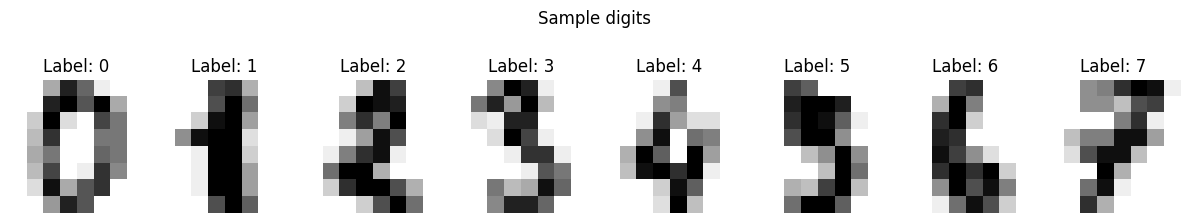

In [2]:
# Load data
digits = load_digits()
X: pd.DataFrame = pd.DataFrame(digits.data)   # shape: (n_samples, 64)
y: pd.Series = pd.Series(digits.target, name="target")

df = X.copy()
df["target"] = y

print("Shape:", df.shape)
display(df.head())
display(df.describe())

print("\nClass counts:")
display(y.value_counts().sort_index())

# Show a few example images
n_show = 8
fig, axes = plt.subplots(1, n_show, figsize=(12, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap="gray_r")
    ax.set_title(f"Label: {digits.target[i]}")
    ax.axis("off")
plt.suptitle("Sample digits")
plt.tight_layout()
plt.show()

## Preprocessing
	•	Stratified train/test split (preserve class proportions)
	•	Standardize features (mean 0, unit variance) — helps neural net optimization

In [3]:
# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True).sort_index())

Train: (1347, 64)  Test: (450, 64)
Train class balance:
 target
0    0.098738
1    0.100965
2    0.098738
3    0.101707
4    0.100965
5    0.100965
6    0.100965
7    0.099480
8    0.097253
9    0.100223
Name: proportion, dtype: float64


## Modeling

We’ll train:
	1.	From-scratch MLP (one hidden layer, ReLU, softmax, cross-entropy, L2, mini-batch SGD + early stopping)
	2.	scikit-learn MLPClassifier pipeline with scaling
We’ll also run a small GridSearchCV for the sklearn model.

In [4]:
# ---------- From-scratch MLP (1 hidden layer, ReLU + softmax) ----------
class SimpleMLPClassifier:
    """
    Minimal MLP for multiclass classification.
    Architecture: [input -> Dense(ReLU, H) -> Dense(softmax, C)]
    - Loss: cross-entropy
    - Optimizer: mini-batch SGD
    - Regularization: L2 (weight decay), no penalty on biases
    - Early stopping on validation loss
    For teaching; not as fast/robust as sklearn.
    """
    def __init__(
        self,
        hidden_units: int = 64,
        lr: float = 0.05,
        epochs: int = 100,
        batch_size: int = 64,
        l2: float = 1e-4,
        patience: int = 10,
        verbose: bool = False,
        random_state: Optional[int] = 42
    ):
        self.hidden_units = int(hidden_units)
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.l2 = float(l2)
        self.patience = int(patience)
        self.verbose = bool(verbose)
        self.random_state = random_state

        # learned params
        self.W1_: Optional[np.ndarray] = None
        self.b1_: Optional[np.ndarray] = None
        self.W2_: Optional[np.ndarray] = None
        self.b2_: Optional[np.ndarray] = None
        self.classes_: Optional[np.ndarray] = None

        # history
        self.history_: Dict[str, List[float]] = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    @staticmethod
    def _relu(z: np.ndarray) -> np.ndarray:
        return np.maximum(0.0, z)

    @staticmethod
    def _relu_grad(z: np.ndarray) -> np.ndarray:
        g = np.zeros_like(z)
        g[z > 0] = 1.0
        return g

    @staticmethod
    def _softmax(logits: np.ndarray) -> np.ndarray:
        # logits: (n, C)
        z = logits - logits.max(axis=1, keepdims=True)
        exp = np.exp(z)
        return exp / (exp.sum(axis=1, keepdims=True) + 1e-12)

    def _init_params(self, d: int, H: int, C: int):
        rng = np.random.RandomState(self.random_state)
        # He init for ReLU
        self.W1_ = rng.randn(d, H) * np.sqrt(2.0 / d)
        self.b1_ = np.zeros((1, H))
        # Xavier for output
        self.W2_ = rng.randn(H, C) * np.sqrt(1.0 / H)
        self.b2_ = np.zeros((1, C))

    def _forward(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        Z1 = X @ self.W1_ + self.b1_      # (n,H)
        A1 = self._relu(Z1)               # (n,H)
        logits = A1 @ self.W2_ + self.b2_ # (n,C)
        probs = self._softmax(logits)     # (n,C)
        return Z1, A1, probs

    @staticmethod
    def _one_hot(y: np.ndarray, C: int) -> np.ndarray:
        Y = np.zeros((y.shape[0], C), dtype=float)
        Y[np.arange(y.shape[0]), y] = 1.0
        return Y

    def _loss(self, probs: np.ndarray, y: np.ndarray) -> float:
        # mean cross-entropy
        eps = 1e-12
        ce = -np.log(probs[np.arange(y.size), y] + eps).mean()
        # L2 penalty (weights only)
        l2_term = 0.0
        if self.l2 > 0:
            l2_term = 0.5 * self.l2 * (np.sum(self.W1_**2) + np.sum(self.W2_**2))
        return ce + l2_term

    def _accuracy(self, probs: np.ndarray, y: np.ndarray) -> float:
        preds = np.argmax(probs, axis=1)
        return (preds == y).mean()

    def fit(
        self,
        X: Union[pd.DataFrame, np.ndarray],
        y: Union[pd.Series, np.ndarray],
        validation_split: float = 0.15
    ):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)
        n, d = X.shape
        self.classes_ = np.unique(y)
        C = self.classes_.size

        # map y to {0..C-1} if needed
        if not np.array_equal(self.classes_, np.arange(C)):
            # create mapping
            class_to_idx = {c:i for i,c in enumerate(self.classes_)}
            y = np.array([class_to_idx[yi] for yi in y], dtype=int)

        # train/val split
        n_val = int(round(validation_split * n))
        if n_val > 0:
            X_tr, X_val = X[:-n_val], X[-n_val:]
            y_tr, y_val = y[:-n_val], y[-n_val:]
        else:
            X_tr, y_tr = X, y
            X_val, y_val = X[:0], y[:0]

        # initialize params
        self._init_params(d, self.hidden_units, C)

        # training loop
        best_val = np.inf
        wait = 0
        idx = np.arange(X_tr.shape[0])

        for ep in range(self.epochs):
            np.random.shuffle(idx)
            # mini-batch SGD
            for start in range(0, X_tr.shape[0], self.batch_size):
                batch_idx = idx[start:start + self.batch_size]
                Xb = X_tr[batch_idx]
                yb = y_tr[batch_idx]

                # forward
                Z1, A1, probs = self._forward(Xb)
                # gradients (softmax + CE)
                dlogits = probs
                dlogits[np.arange(yb.size), yb] -= 1.0
                dlogits /= yb.size

                dW2 = A1.T @ dlogits + self.l2 * self.W2_
                db2 = dlogits.sum(axis=0, keepdims=True)

                dA1 = dlogits @ self.W2_.T
                dZ1 = dA1 * self._relu_grad(Z1)

                dW1 = Xb.T @ dZ1 + self.l2 * self.W1_
                db1 = dZ1.sum(axis=0, keepdims=True)

                # update
                self.W2_ -= self.lr * dW2
                self.b2_ -= self.lr * db2
                self.W1_ -= self.lr * dW1
                self.b1_ -= self.lr * db1

            # end epoch: compute losses/acc
            _, _, probs_tr = self._forward(X_tr)
            train_loss = self._loss(probs_tr, y_tr)
            train_acc  = self._accuracy(probs_tr, y_tr)

            if n_val > 0:
                _, _, probs_val = self._forward(X_val)
                val_loss = self._loss(probs_val, y_val)
                val_acc  = self._accuracy(probs_val, y_val)
            else:
                val_loss, val_acc = np.nan, np.nan

            self.history_["train_loss"].append(float(train_loss))
            self.history_["val_loss"].append(float(val_loss))
            self.history_["train_acc"].append(float(train_acc))
            self.history_["val_acc"].append(float(val_acc))

            if self.verbose and (ep % 10 == 0 or ep == self.epochs - 1):
                print(f"epoch {ep:3d} | loss {train_loss:.4f} | val {val_loss:.4f} | acc {train_acc:.3f} | val_acc {val_acc:.3f}")

            # early stopping on val loss
            if n_val > 0:
                if val_loss < best_val - 1e-6:
                    best_val = val_loss
                    wait = 0
                    best_params = (self.W1_.copy(), self.b1_.copy(), self.W2_.copy(), self.b2_.copy())
                else:
                    wait += 1
                    if wait >= self.patience:
                        if self.verbose:
                            print(f"Early stopping at epoch {ep}. Restoring best weights.")
                        self.W1_, self.b1_, self.W2_, self.b2_ = best_params
                        break

        return self

    def predict_proba(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        X = np.asarray(X, dtype=float)
        _, _, probs = self._forward(X)
        return probs

    def predict(self, X: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        probs = self.predict_proba(X)
        preds = np.argmax(probs, axis=1)
        # map back to original class labels if needed
        if np.array_equal(self.classes_, np.arange(self.classes_.size)):
            return preds
        else:
            return self.classes_[preds]

In [5]:
# Scale data for both models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 1) From-scratch MLP
mlp_scratch = SimpleMLPClassifier(
    hidden_units=64, lr=0.05, epochs=150, batch_size=64,
    l2=1e-4, patience=15, verbose=False, random_state=42
).fit(X_train_scaled, y_train)

# 2) scikit-learn MLPClassifier in a Pipeline
mlp_sklearn = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        solver="adam",
        alpha=1e-4,            # L2
        learning_rate_init=0.001,
        max_iter=400,
        random_state=42
    ))
])
mlp_sklearn.fit(X_train, y_train)

,steps,"[('scaler', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,hidden_layer_sizes,"(64,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001


## Hyperparameter Tuning (sklearn)

We’ll tune hidden_layer_sizes, alpha (L2), and learning_rate_init. Keep the grid small for speed.

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (64, 32)],
    "mlp__alpha": [1e-4, 5e-4, 1e-3],
    "mlp__learning_rate_init": [0.001, 0.01],
}

mlp_grid = GridSearchCV(
    estimator=Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            activation="relu", solver="adam", max_iter=400, random_state=42
        ))
    ]),
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

mlp_grid.fit(X_train, y_train)
print("Best params:", mlp_grid.best_params_)
print("Best CV accuracy:", mlp_grid.best_score_)
mlp_best = mlp_grid.best_estimator_

Best params: {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64,), 'mlp__learning_rate_init': 0.001}
Best CV accuracy: 0.9769792096929646


## Evaluation

We’ll compute accuracy, confusion matrices, classification reports, and macro ROC-AUC (OvR).
We’ll also plot the learning curves (loss/accuracy) for the from-scratch MLP.

In [7]:
def evaluate_multiclass(name: str, model, X_te, y_te, label_names=None):
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    # Multiclass ROC-AUC with OvR requires predict_proba
    auc = np.nan
    try:
        proba = model.predict_proba(X_te)
        auc = roc_auc_score(y_te, proba, multi_class="ovr", average="macro")
    except Exception:
        pass

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | Macro ROC-AUC (OvR): {auc if not np.isnan(auc) else 'N/A'}")
    print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
    print("Classification report:\n", classification_report(y_te, y_pred, target_names=label_names))
    return acc, auc

acc_scratch, auc_scratch = evaluate_multiclass("MLP (scratch)", mlp_scratch, X_test_scaled, y_test, [str(i) for i in range(10)])
acc_sklearn, auc_sklearn = evaluate_multiclass("MLP (sklearn)", mlp_sklearn, X_test, y_test, [str(i) for i in range(10)])
acc_best, auc_best = evaluate_multiclass("MLP (tuned)", mlp_best, X_test, y_test, [str(i) for i in range(10)])


=== MLP (scratch) ===
Accuracy: 0.9689 | Macro ROC-AUC (OvR): 0.9957913568102381
Confusion matrix:
 [[44  0  0  0  1  0  0  0  0  0]
 [ 0 45  0  0  1  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  1 45  0  0  0  0  0  0]
 [ 0  0  0  0 43  0  0  2  0  0]
 [ 0  0  0  0  0 45  0  0  0  1]
 [ 0  0  0  0  0  0 44  0  1  0]
 [ 0  0  0  0  0  0  0 45  0  0]
 [ 0  4  0  1  0  0  0  1 37  0]
 [ 0  0  0  0  0  0  0  1  0 44]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.92      0.98      0.95        46
           2       0.98      1.00      0.99        44
           3       0.98      0.98      0.98        46
           4       0.96      0.96      0.96        45
           5       1.00      0.98      0.99        46
           6       1.00      0.98      0.99        45
           7       0.92      1.00      0.96        45
           8       0.97      0.86      0.91        43
   

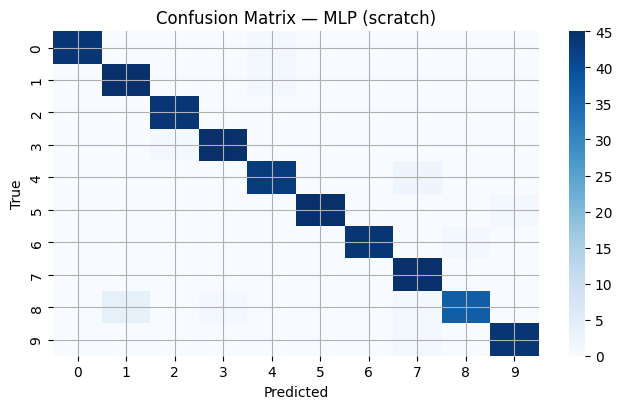

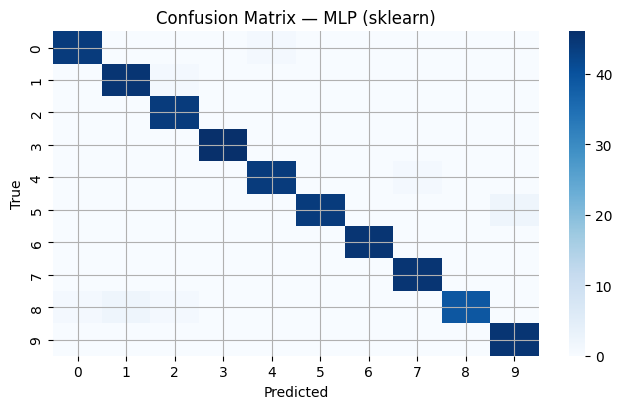

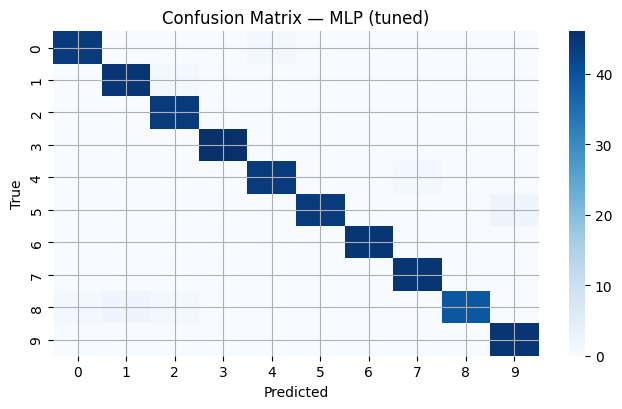

In [8]:
# Pretty confusion matrices
def plot_cm(model_name: str, model, X_te, y_te):
    y_pred = model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)
    if sns is not None:
        plt.figure()
        sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
        plt.title(f"Confusion Matrix — {model_name}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()
    else:
        print(f"{model_name} confusion matrix:\n{cm}")

plot_cm("MLP (scratch)", mlp_scratch, X_test_scaled, y_test)
plot_cm("MLP (sklearn)", mlp_sklearn, X_test, y_test)
plot_cm("MLP (tuned)", mlp_best, X_test, y_test)

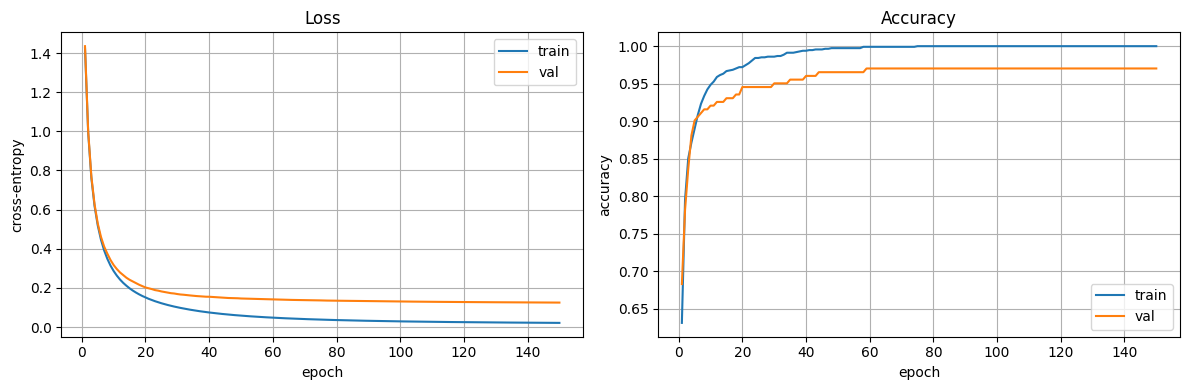

In [9]:
# Learning curves for the from-scratch MLP
hist = mlp_scratch.history_
epochs_r = range(1, len(hist["train_loss"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(epochs_r, hist["train_loss"], label="train")
ax[0].plot(epochs_r, hist["val_loss"], label="val")
ax[0].set_title("Loss"); ax[0].set_xlabel("epoch"); ax[0].set_ylabel("cross-entropy")
ax[0].legend()

ax[1].plot(epochs_r, hist["train_acc"], label="train")
ax[1].plot(epochs_r, hist["val_acc"], label="val")
ax[1].set_title("Accuracy"); ax[1].set_xlabel("epoch"); ax[1].set_ylabel("accuracy")
ax[1].legend()

plt.tight_layout(); plt.show()

## Key Takeaways
	•	MLP = multiple linear layers + nonlinear activations (e.g., ReLU) trained with backpropagation to minimize cross-entropy.
	•	Unlike the single-layer Perceptron, MLPs can represent nonlinear decision boundaries.
	•	Regularization (alpha in sklearn; L2 weight decay here) and early stopping help prevent overfitting.
	•	Scaling inputs (StandardScaler) usually improves optimization.
	•	Tune: hidden_layer_sizes, activation, alpha (L2), learning_rate_init, batch_size, max_iter.